In [4]:
!pip install lazypredict
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from gensim.models import FastText
from nltk.tokenize import word_tokenize
import nltk
from lazypredict.Supervised import LazyClassifier

In [5]:
# Download necessary NLTK data
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# 2. Text Representation
def get_fasttext_embeddings(model_path):
    return FastText.load_fasttext_format(model_path)

def tokenize_text(text):
    return word_tokenize(text.lower())

def get_text_embedding(text, model):
    tokens = tokenize_text(text)
    word_vectors = [model[word] for word in tokens if word in model]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

def prepare_data(data, fasttext_model):
    X = np.array([get_text_embedding(review, fasttext_model) for review in data['review']])
    y = (data['sentiment'] == 'positive').astype(int)
    return X, y


In [14]:

# 3. Model Training
def train_models(X_train, y_train):
    lr_model = LogisticRegression(random_state=42)
    rf_model = RandomForestClassifier(random_state=42)

    lr_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)

    return lr_model, rf_model

def train_lazy_models(X_train, X_test, y_train, y_test):
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    return models, predictions



# 4. Evaluation
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            results[name] = {
                'fpr': fpr.tolist(),  # Convert to list for JSON serialization
                'tpr': tpr.tolist(),
                'auc': roc_auc,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }
        else:
            print(f"Model '{name}' does not have a predict_proba method. Skipping...")
    return results


# Function to print evaluation metrics
def print_evaluation_metrics(results):
    print("\nEvaluation Metrics:")
    print("-------------------")
    for name, metrics in results.items():
        print(f"\nModel: {name}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        print(f"AUC: {metrics['auc']:.4f}")

# Function to print LazyPredict results
def print_lazy_predict_results(predictions):
    print("\nLazyPredict Model Results:")
    print("---------------------------")
    print(predictions)

def plot_roc_curves(results):
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()



In [15]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


--2024-06-27 16:52:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.11, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.1’

wiki-news-300d-1M.v 100%[===================>] 650.22M   119MB/s    in 10s     

2024-06-27 16:52:21 (64.5 MB/s) - ‘wiki-news-300d-1M.vec.zip.1’ saved [681808098/681808098]



In [16]:
!unzip wiki-news-300d-1M.vec.zip


Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
# 1. Data Preparation
import os
def load_data(positive_path, negative_path):
    data = {'review': [], 'sentiment': []}

    # Load positive reviews
    with open(positive_path, 'r', encoding='utf-8') as file:
        positive_reviews = file.readlines()
        data['review'].extend(positive_reviews)
        data['sentiment'].extend(['positive'] * len(positive_reviews))

    # Load negative reviews
    with open(negative_path, 'r', encoding='utf-8') as file:
        negative_reviews = file.readlines()
        data['review'].extend(negative_reviews)
        data['sentiment'].extend(['negative'] * len(negative_reviews))

    return pd.DataFrame(data)

# Load FastText word vectors into memory
import gensim
def load_fasttext_vectors(vec_file):
    print("Loading FastText word vectors...")
    model = gensim.models.KeyedVectors.load_word2vec_format(vec_file, binary=False)
    print("Word vectors loaded.")
    return model

fasttext_vec_file = "wiki-news-300d-1M.vec"


Loading FastText word vectors...
Word vectors loaded.


 97%|█████████▋| 28/29 [03:14<00:07,  7.79s/it]

[LightGBM] [Info] Number of positive: 6385, number of negative: 2613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 8998, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709602 -> initscore=0.893453
[LightGBM] [Info] Start training from score 0.893453


100%|██████████| 29/29 [03:21<00:00,  6.95s/it]



LazyPredict Model Results:
---------------------------
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.96               0.94     0.94      0.96   
LinearSVC                          0.95               0.94     0.94      0.95   
LogisticRegression                 0.95               0.94     0.94      0.95   
CalibratedClassifierCV             0.95               0.93     0.93      0.95   
PassiveAggressiveClassifier        0.94               0.93     0.93      0.94   
LGBMClassifier                     0.94               0.92     0.92      0.94   
SGDClassifier                      0.93               0.92     0.92      0.93   
XGBClassifier                      0.94               0.92     0.92      0.94   
Perceptron                         0.93               0.92     0.92      0.93   
LinearDiscriminantAnalysis         0.94              

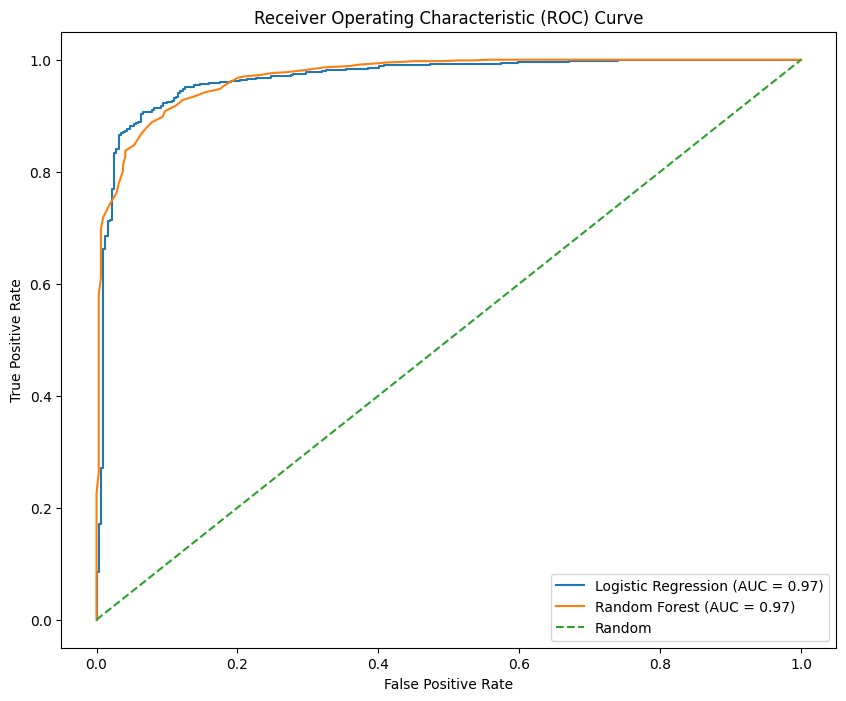

In [18]:
# Main execution
def main():
    # Load data
    data = load_data('/content/TrainingDataPositive.txt', '/content/TrainingDataNegative.txt')

    # Split data into train and test sets
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    # Further split test data into test and validation sets
    test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

    # Load FastText word vectors
    fasttext_model = load_fasttext_vectors(fasttext_vec_file)

    # Prepare data
    X_train, y_train = prepare_data(train_data, fasttext_model)
    X_test, y_test = prepare_data(test_data, fasttext_model)
    X_val, y_val = prepare_data(val_data, fasttext_model)

    # Train models
    lr_model, rf_model = train_models(X_train, y_train)

    # Train lazy models and get predictions
    lazy_models, lazy_predictions = train_lazy_models(X_train, X_val, y_train, y_val)

    # Print LazyPredict results
    print_lazy_predict_results(lazy_predictions)

    # Evaluate custom models
    custom_models = {'Logistic Regression': lr_model, 'Random Forest': rf_model}
    custom_results = evaluate_models(custom_models, X_test, y_test)

    # Print evaluation metrics for custom models
    print_evaluation_metrics(custom_results)

    # Plot ROC curves for custom models
    plot_roc_curves(custom_results)

if __name__ == "__main__":
    main()